## ToDos:
1. Train-Test-Split
2. EDA
3. Impute missing values
4. BaseLine Model
5. Make Features and Target Stationary
6. Model 

In [398]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
sns.set()

import eda
from function_model import RSME, MAE, plot_model_performance, walk_forward_prediction_ARIMA, create_season

In [313]:
%load_ext autoreload
%autoreload 2

## Read Data

In [2]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv", index_col=0, parse_dates=True, dayfirst=True)
df.index.freq = 'D'

### Rename Columns

In [3]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
df.columns = columns

Index(['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')


In [4]:
df.head(1)

,Rf_BU,DtG_P24,DtG_P25,T_BU,T_Pe,V_Pe,H_FCP
Date,,,,,,,
2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN


In [5]:
df.count()

Rf_BU      4199
DtG_P24    5168
DtG_P25    5184
T_BU       4199
T_Pe       4199
V_Pe       5025
H_FCP      4199
dtype: int64

In [6]:
df.isna().sum()

Rf_BU      1024
DtG_P24      55
DtG_P25      39
T_BU       1024
T_Pe       1024
V_Pe        198
H_FCP      1024
dtype: int64

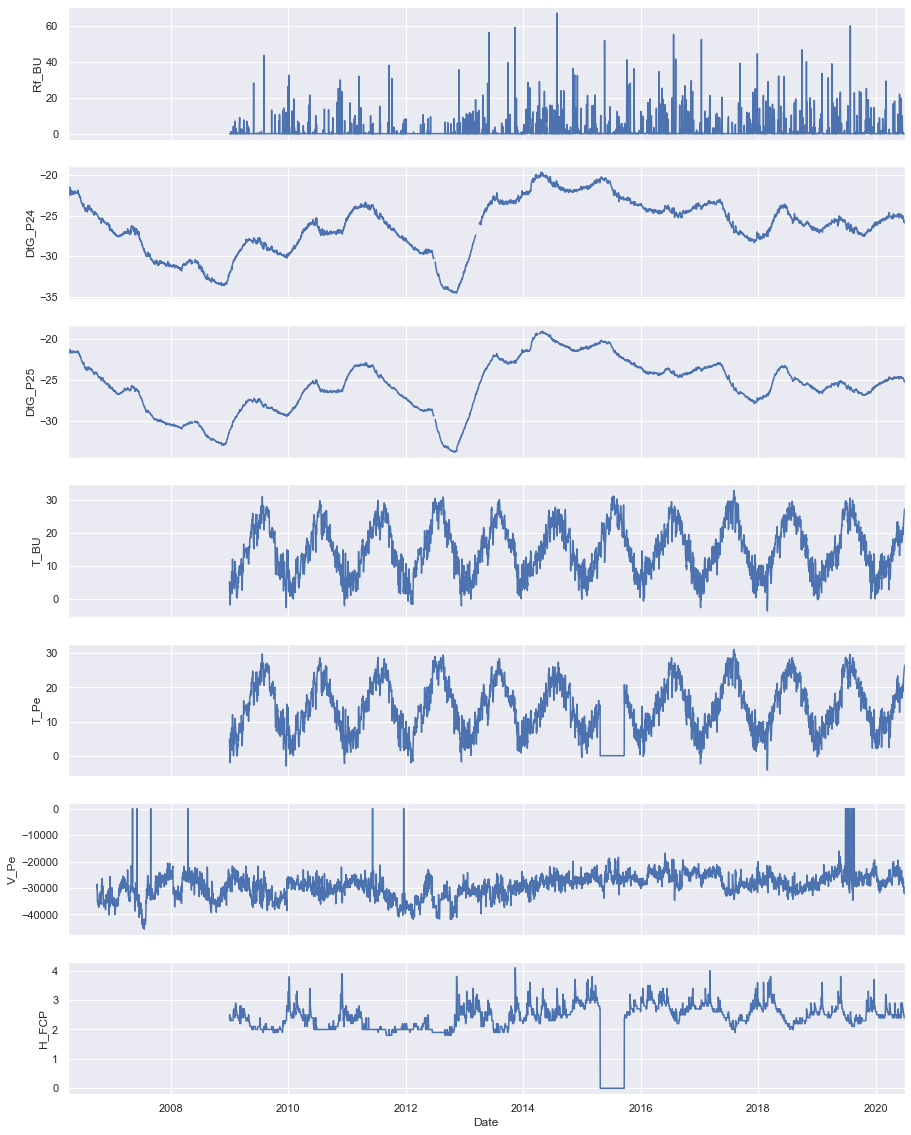

In [7]:
eda.plot_time_series(df, '2006-04-01', '2020-06-30', (15, 20))

### Replace zero values of V_Pe, H_FCP, T_Pe with NaN

In [368]:
df_imputed = df.copy()

In [369]:
df_imputed['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_imputed['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_imputed['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])

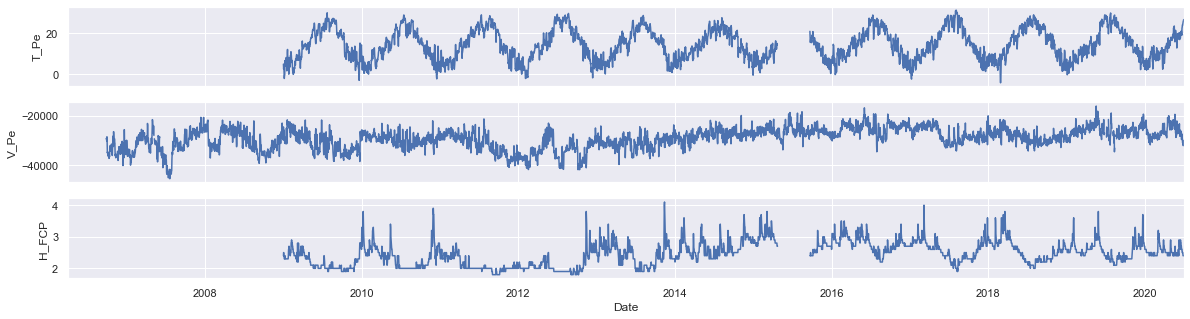

In [370]:
eda.plot_time_series(df_imputed[['T_Pe', 'V_Pe', 'H_FCP']], '2006-04-01', '2020-06-30', (20,5))

### Replace NaN in dataset

#### T_Pe

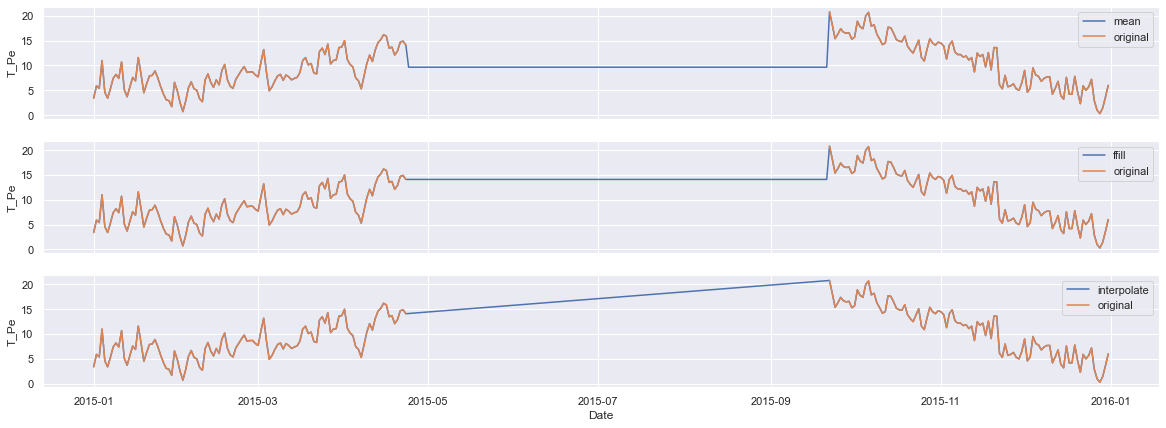

In [24]:
eda.plot_nan_replacement(df_imputed['T_Pe'], '2015', '2015', (20,7)) 

#### V_Pe

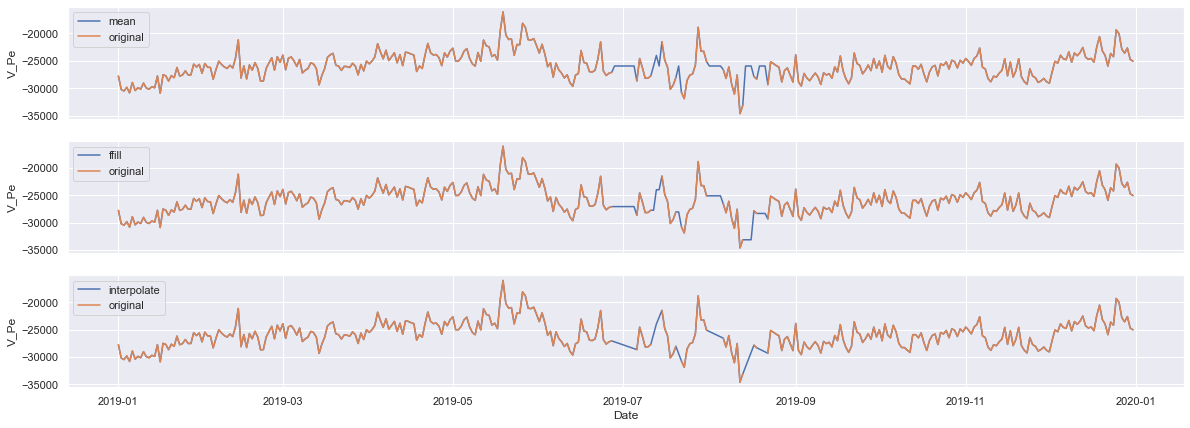

In [23]:
eda.plot_nan_replacement(df_imputed['V_Pe'], '2019', '2019', (20,7)) 

#### H_FCP

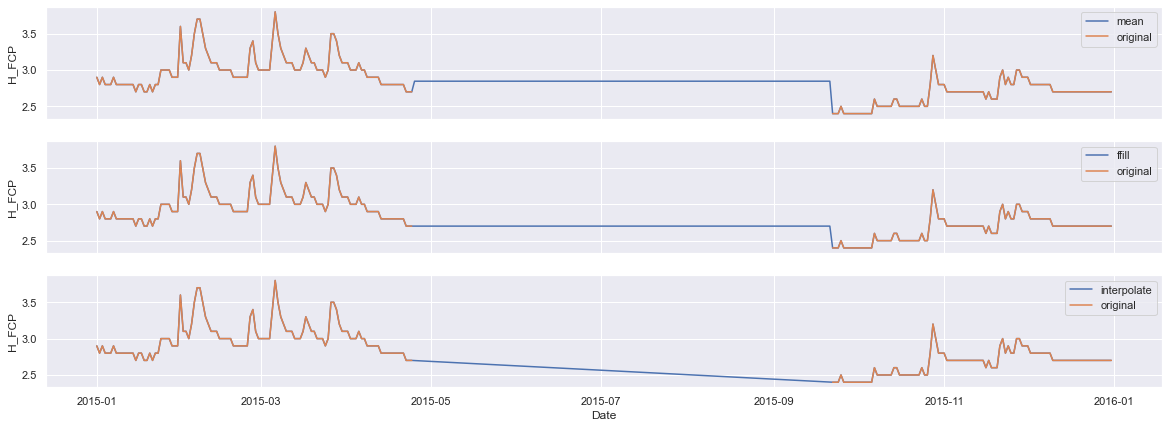

In [25]:
eda.plot_nan_replacement(df_imputed['H_FCP'], '2015', '2015', (20,7))

#### DtG_P24

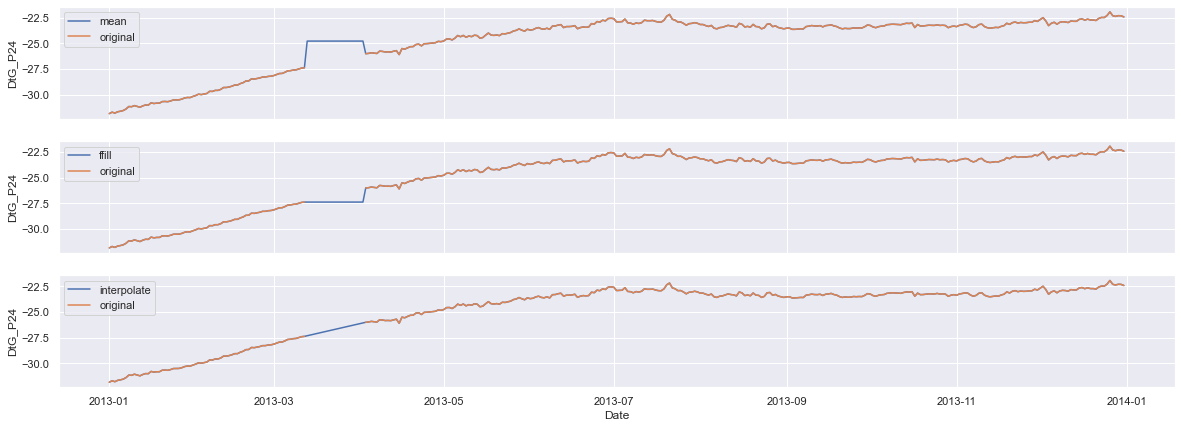

In [26]:
eda.plot_nan_replacement(df_imputed['DtG_P24'], '2013', '2013', (20,7))

### Impute missing values

In [371]:
df_imputed['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])
df_imputed['V_Pe'] = df_imputed['V_Pe'].interpolate()
df_imputed['H_FCP'] = df_imputed['H_FCP'].interpolate()
df_imputed['DtG_P25'] = df_imputed['DtG_P25'].interpolate()
df_imputed['DtG_P24'] = df_imputed['DtG_P24'].interpolate()

## Check for consistent spacing

In [11]:
(df_imputed.index - df_imputed.index.shift(-1)).value_counts()

1 days    5223
Name: Date, dtype: int64

## Downsampling to a weekly interval to reduce noise

In [101]:
col_mean = ['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU']
col_sum = ['Rf_BU']
df_weekly = df_imputed[col_mean].resample('7D').mean()
df_weekly['Rf_BU'] = df_imputed[col_sum].resample('7D').sum()
df_weekly = df_weekly.loc['2009':]

## EDA

### Decompose features

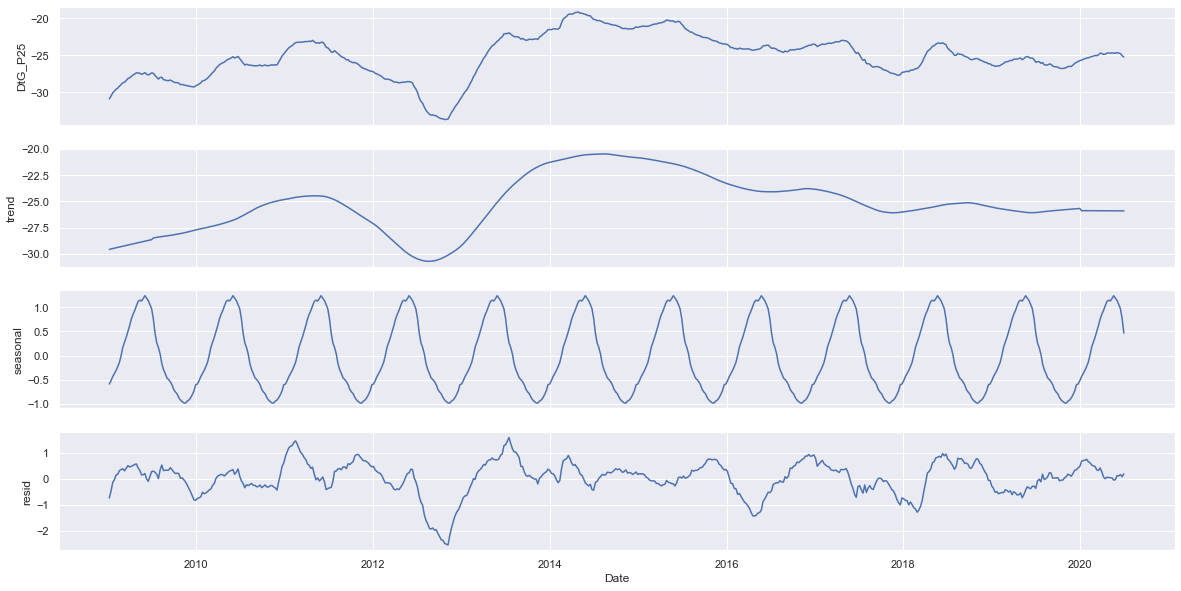

In [35]:
y_decompose = eda.decompose_features(df_weekly['DtG_P25'], 52)

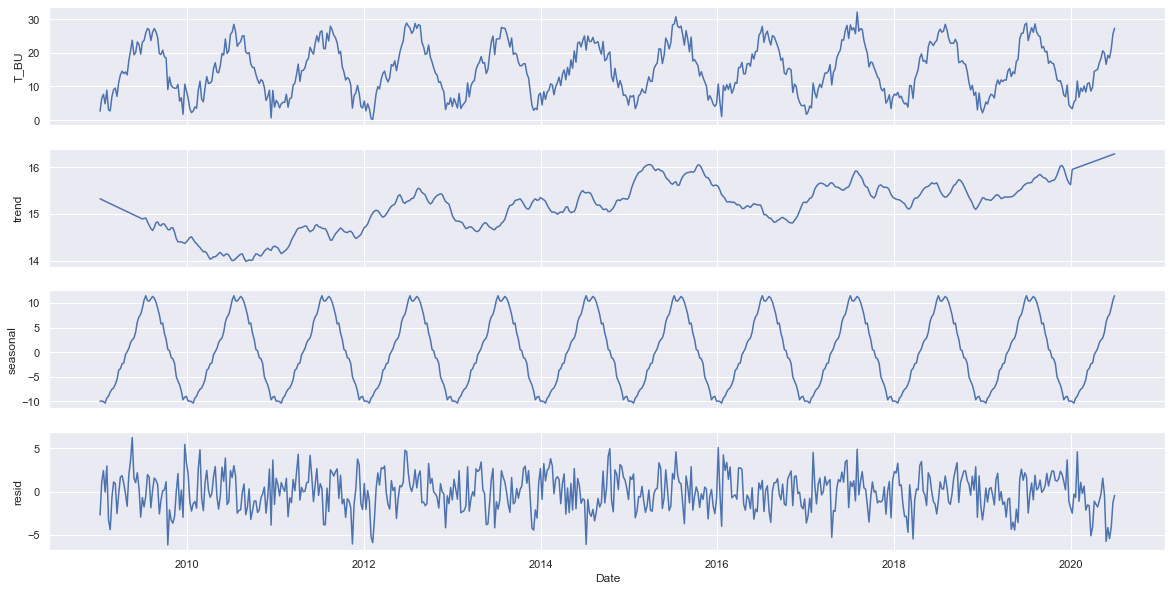

In [37]:
temp_decompose = eda.decompose_features(df_weekly['T_BU'], 52)

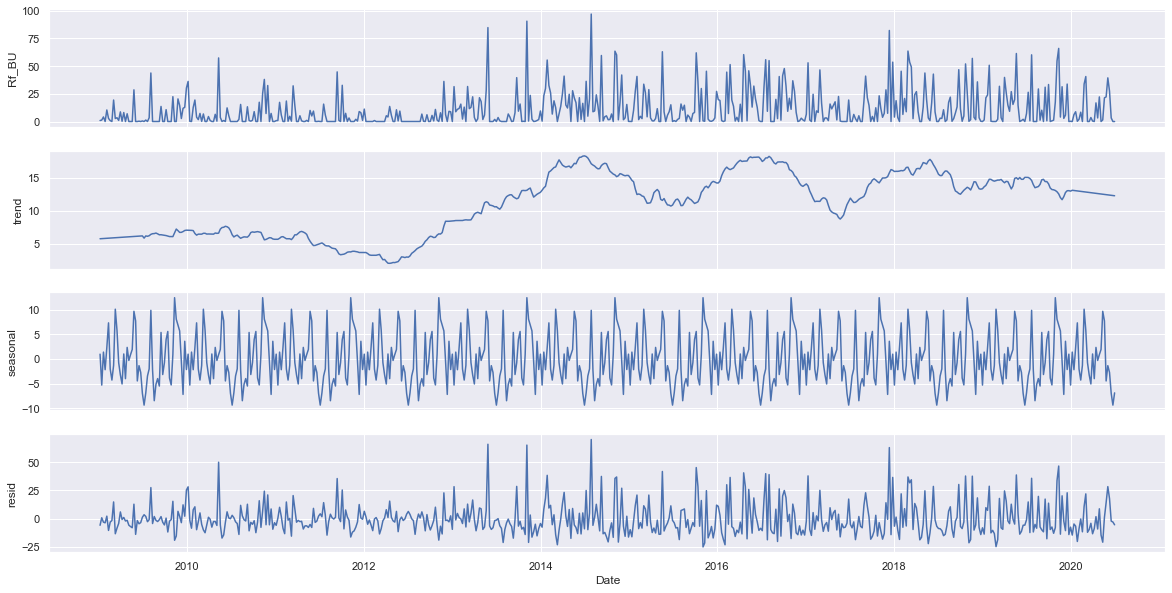

In [38]:
rainfall_decompose = eda.decompose_features(df_weekly['Rf_BU'], 52)

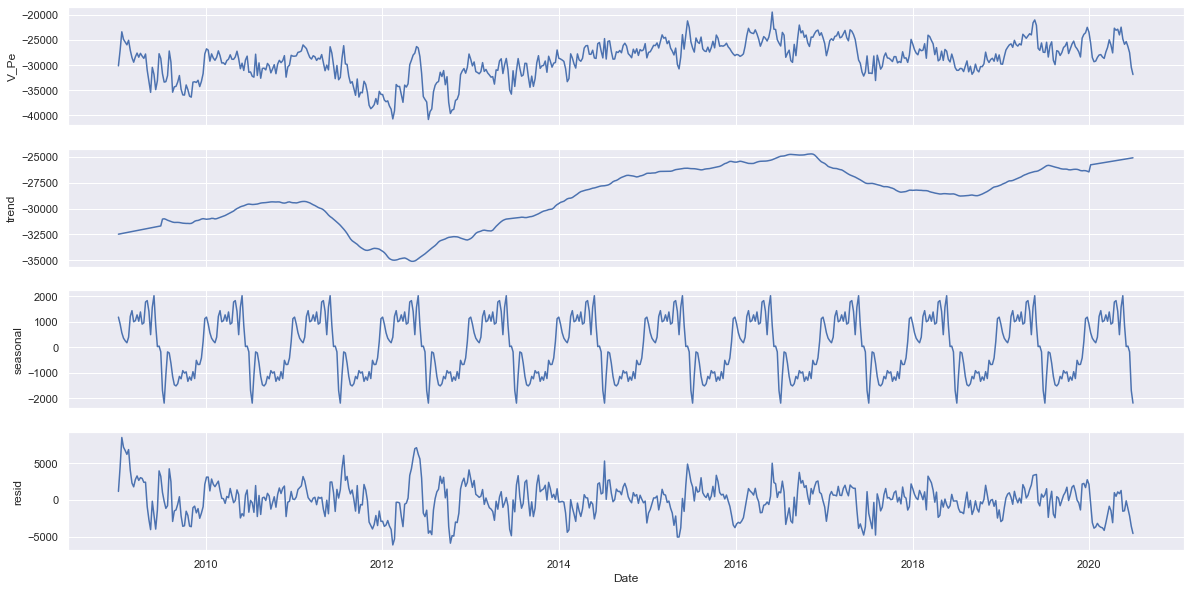

In [40]:
extraction_decompose = eda.decompose_features(df_weekly['V_Pe'], 52)

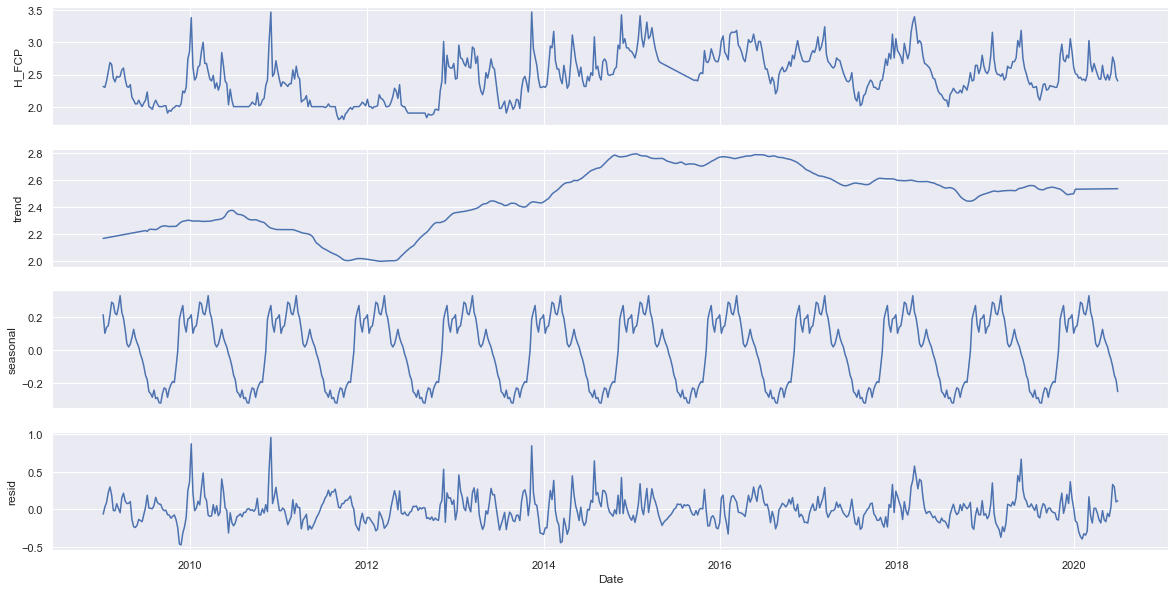

In [42]:
hydrometry_decompose = eda.decompose_features(df_weekly['H_FCP'], 52)

### Create new dataframe with all decomposed features

In [96]:
df_decomposed = pd.DataFrame(index=df_weekly.index)
features = [y_decompose, temp_decompose, rainfall_decompose, extraction_decompose, hydrometry_decompose]
for feature in features:
    df_decomposed[f'{feature.observed.name}'] = feature.observed
    df_decomposed[f'{feature.observed.name}_trend'] = feature.trend
    df_decomposed[f'{feature.observed.name}_seasonal'] = feature.seasonal

### Plot all trends of features

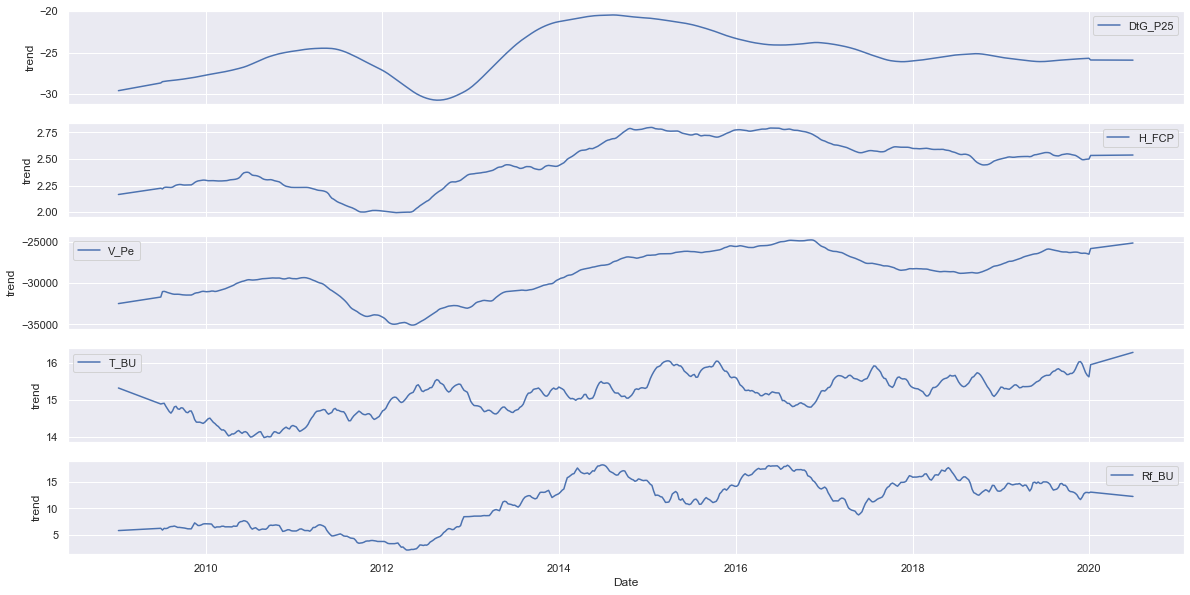

In [95]:
eda.plot_all_decomposed_trends(df_weekly, 52, '2009-01-01', '2021-01-01')

### Create lagged trends for Volume, Hydrometry and Rainfall

In [97]:
df_decomposed['V_Pe_trend_4M'] = df_decomposed['V_Pe_trend'].shift(4*4)
df_decomposed['H_FCP_trend_6M'] = df_decomposed['H_FCP_trend'].shift(6*4)
df_decomposed['Rf_BU_trend_6M'] = df_decomposed['Rf_BU_trend'].shift(6*4)

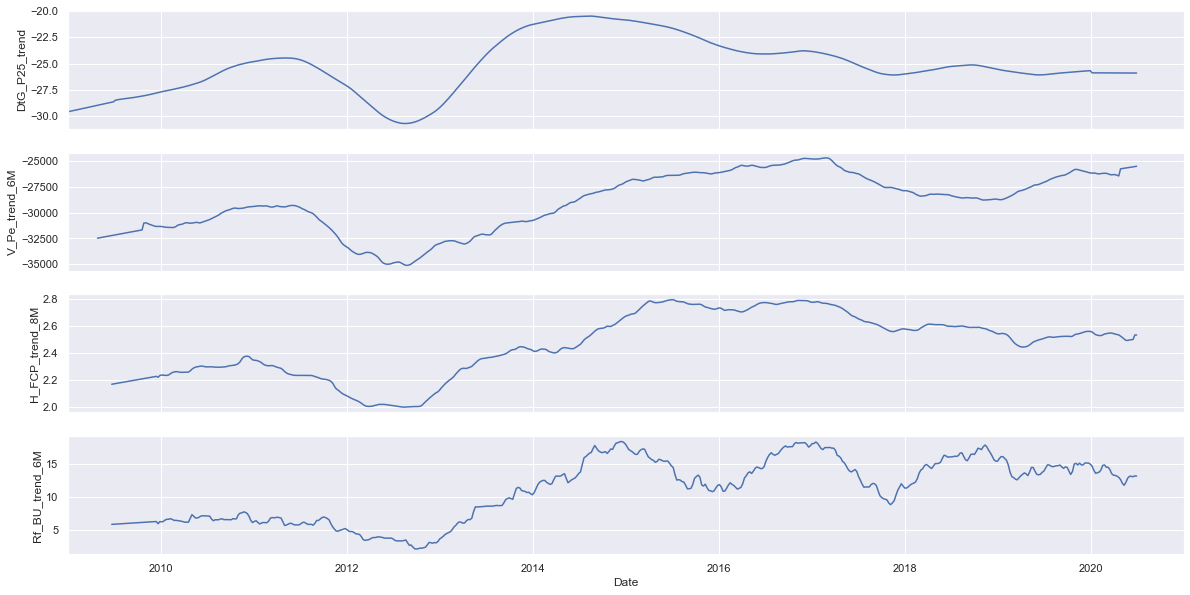

In [91]:
eda.plot_time_series(df_decomposed[['DtG_P25_trend', 'V_Pe_trend_4M', 'H_FCP_trend_6M', 'Rf_BU_trend_6M']],'2009-01-01', '2021-01-01' ,plotsize=(20,10))

### Correlation plots of trends

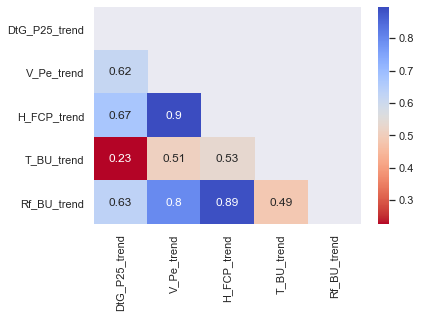

In [98]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend', 'H_FCP_trend', 'T_BU_trend', 'Rf_BU_trend']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend, cmap='coolwarm_r', annot=True, mask=np.triu(corr_trend))

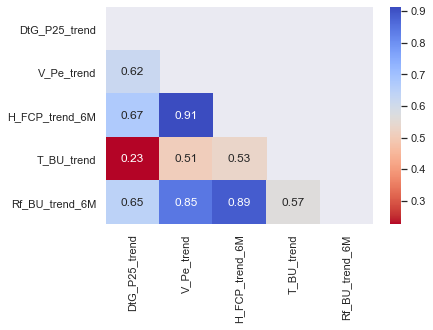

In [99]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend', 'H_FCP_trend_6M', 'T_BU_trend','Rf_BU_trend_6M']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend, cmap='coolwarm_r', annot=True, mask=np.triu(corr_trend))

### Plot all seasonal components of features

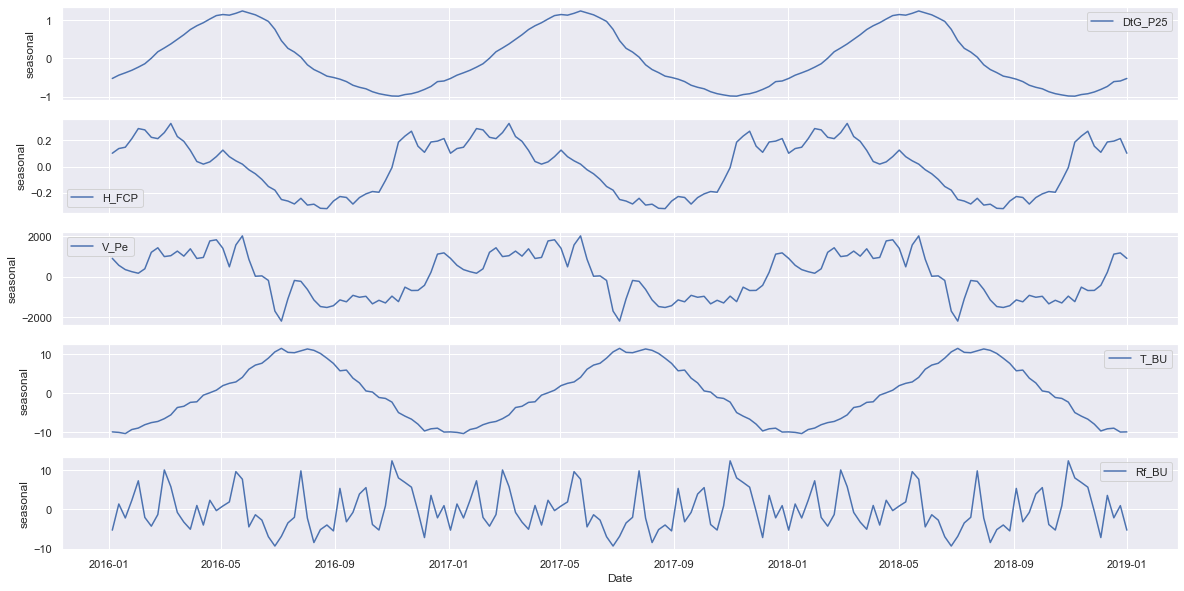

In [102]:
eda.plot_all_decomposed_seasonality(df_weekly, 52, '2016-01-01', '2019-01-01')

In [104]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal', 'Rf_BU_seasonal']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal,H_FCP_seasonal,T_BU_seasonal,Rf_BU_seasonal
,mean,mean,mean,mean,mean
Date,,,,,
1,-0.42,563.49,0.16,-9.87,-0.24
2,-0.04,797.03,0.25,-7.88,0.38
3,0.48,1138.14,0.23,-4.47,1.29
4,0.95,1342.23,0.05,-0.66,-0.78
5,1.17,1334.15,0.06,2.98,3.81
6,1.03,-71.77,-0.10,7.91,-4.07
7,0.29,-1052.18,-0.25,10.76,-2.40
8,-0.32,-1170.83,-0.30,10.13,-4.22


In [1055]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal_1M,H_FCP_seasonal_3M,T_BU_seasonal_2Mr
,mean,mean,mean,mean
Date,,,,
1,-0.42,449.84,-0.11,-4.88
2,-0.04,516.18,0.20,-1.21
3,0.48,844.41,0.17,2.30
4,0.95,1133.13,0.18,7.10
5,1.17,1371.08,0.25,10.60
6,1.03,1303.03,0.18,10.59
7,0.29,-288.23,0.06,6.14
8,-0.32,-911.89,0.03,0.58


## Relative feature lags 
- Groundwater Level - Maximum in Mai/June - Minimum in Oktober/November
- Drainage (inversed negative) - Minimum in March/April - Maximum in June-August
- Hydrometry - Maximum in February/March - Minimum in June - August
- Temperatur - Maximum in June-August - Minimum in January/December
- Rainfall - Maximum in November, Minimum in June - August 

- Temperature lags 2 Month behind Groundwater Level
- Drainage lags -1 Month behind Groundwater Level
- Hydrometry lag -3 Month behind Groundwater Level

### Lagged versions of seasonality H_FCP (3 month), V_Pe (1 month), T_Bu (2 month reverse)

In [106]:
df_decomposed['V_Pe_seasonal_1M'] = df_decomposed['V_Pe_seasonal'].shift(1*4)
df_decomposed['H_FCP_seasonal_3M'] = df_decomposed['H_FCP_seasonal'].shift(3*4)
df_decomposed['T_BU_seasonal_2Mr'] = df_decomposed['T_BU_seasonal'].shift(-2*4)

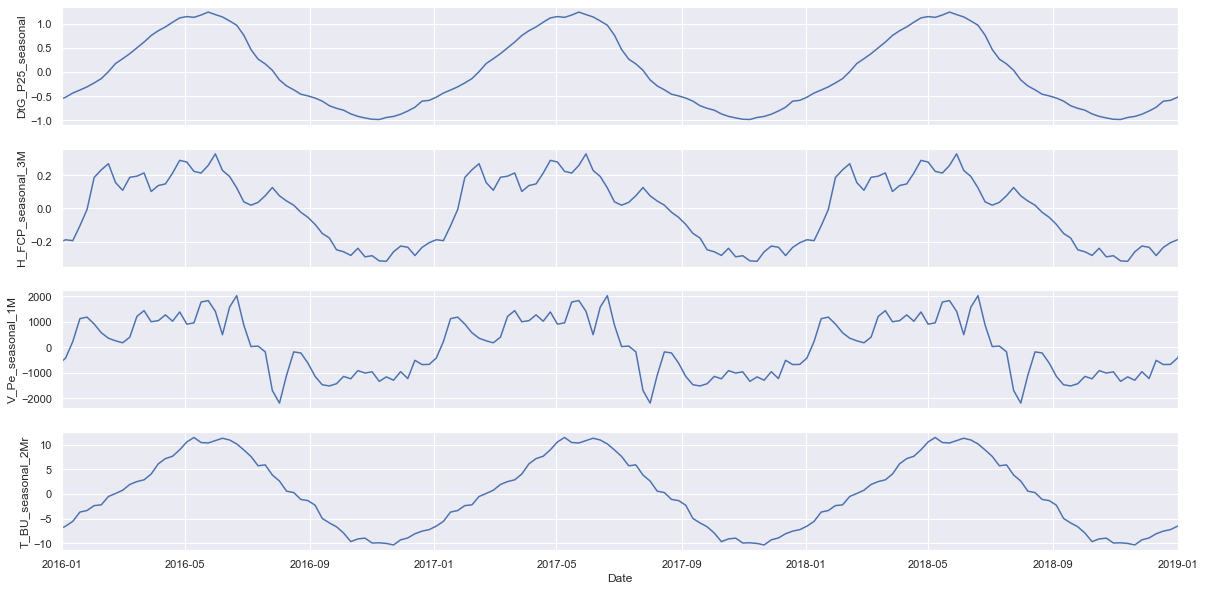

In [108]:
eda.plot_time_series(df_decomposed[['DtG_P25_seasonal', 'H_FCP_seasonal_3M', 'V_Pe_seasonal_1M', 'T_BU_seasonal_2Mr']],'2016-01-01', '2019-01-01' ,plotsize=(20,10))

### Correlation plots of seasonality

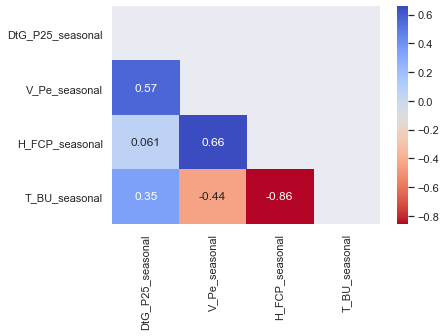

In [110]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True, mask=np.triu(corr_seas))

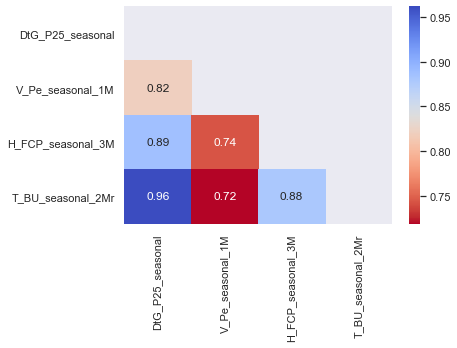

In [111]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True, mask=np.triu(corr_seas))

## Manual decompose

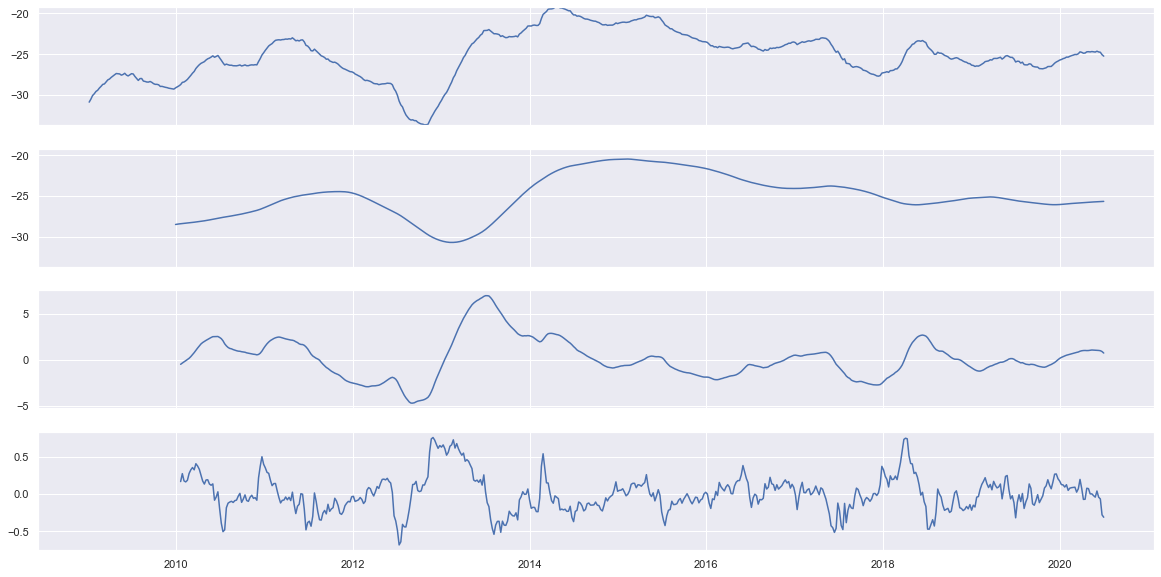

In [112]:
dec_series = df_decomposed.loc['2009-01-01':,'DtG_P25']
trend, seasonality, residual = eda.ma_decompose(dec_series, 52, 4)
eda.plot_decomposition(dec_series, trend, seasonality, residual)

## Train-Test-Split

In [747]:
# Train-Test-Split
df_imputed = df_imputed.loc['2009':]

width = 365
for column in df_imputed:
    lag = df_imputed.shift(width - 1)
    df_imputed[f'{column}_trend'] = lag[column].rolling(window=width).mean()

df_imputed['V_Pe_trend_4M'] = df_imputed['V_Pe_trend'].shift(4*4)
df_imputed['H_FCP_trend_6M'] = df_imputed['H_FCP_trend'].shift(6*4)
df_imputed['Rf_BU_trend_6M'] = df_imputed['Rf_BU_trend'].shift(6*4) 


train = df_imputed[:-52*7]
test = df_imputed[-52*7:]
y_train = train['DtG_P25']
y_test = test['DtG_P25']

## Baseline Model

### Mean

In [337]:
y_pred_mean = pd.Series(y_train.mean(), index=test.index)

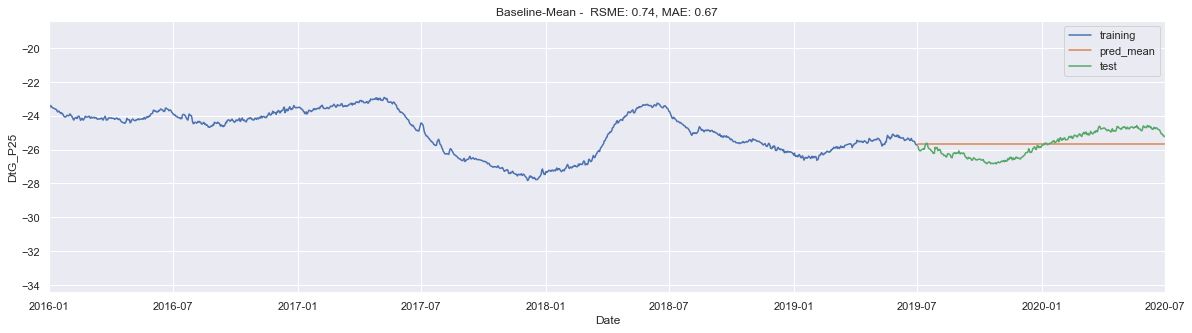

In [338]:
plot_model_performance(y_train, y_pred_mean, y_test, 'Baseline-Mean', '2016-01-01', '2020-07-01')

### Naive Approach

In [339]:
y_pred_naive = pd.Series(y_train[-1], index=test.index)

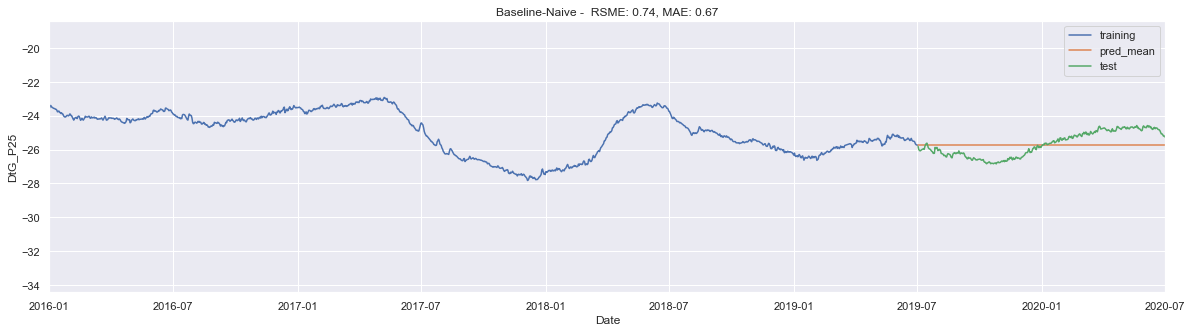

In [340]:
plot_model_performance(y_train, y_pred_naive, y_test, 'Baseline-Naive', '2016-01-01', '2020-07-01')

## ARIMA - univariant

### Adfuller Test for stationarity

In [341]:
result = adfuller(y_train)
print('ADF Statistic: %f' % result[0] + '\np-value: %f' % result[1])

ADF Statistic: -3.061376
p-value: 0.029547


### Differencing to get a stationary series

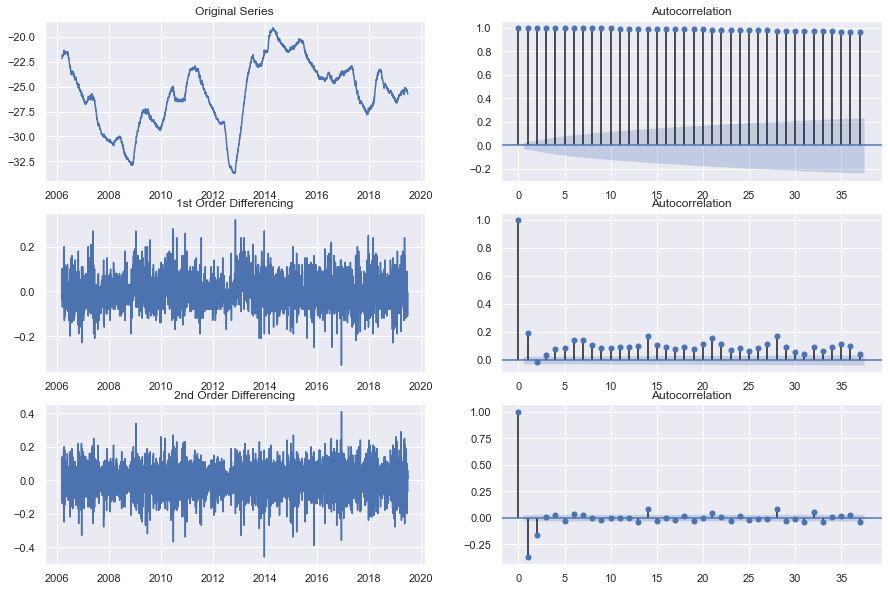

In [342]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0, 0].plot(y_train)
axes[0, 0].set_title('Original Series')
plot_acf(y_train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train.diff().dropna())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_train.diff().dropna().diff().dropna(), ax=axes[2, 1])

plt.show()

/Users/marf/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


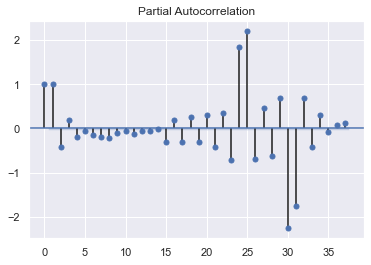

In [347]:
plot_pacf(y_train);

### ARIMA Model

In [348]:
mod = ARIMA(y_train, order=(1,1,1), freq='D')
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.DtG_P25   No. Observations:                 4858
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6653.363
Method:                       css-mle   S.D. of innovations              0.062
Date:                Tue, 16 Feb 2021   AIC                         -13298.727
Time:                        16:44:58   BIC                         -13272.773
Sample:                    03-15-2006   HQIC                        -13289.617
                         - 07-02-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0007      0.001     -0.700      0.484      -0.003       0.001
ar.L1.D.DtG_P25    -0.1030      0.062     -1.650      0.099      -0.225       0.019
ma.L1.D.DtG_P25     0.3073      0.059      5.169      0.000       0.191       0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.7112           +0.0000j            9.7112            0.5000
MA.1           -3.2537           +0.0000j            3.2537            0.5000
-----------------------------------------------------------------------------
"""

#### Plot residuals

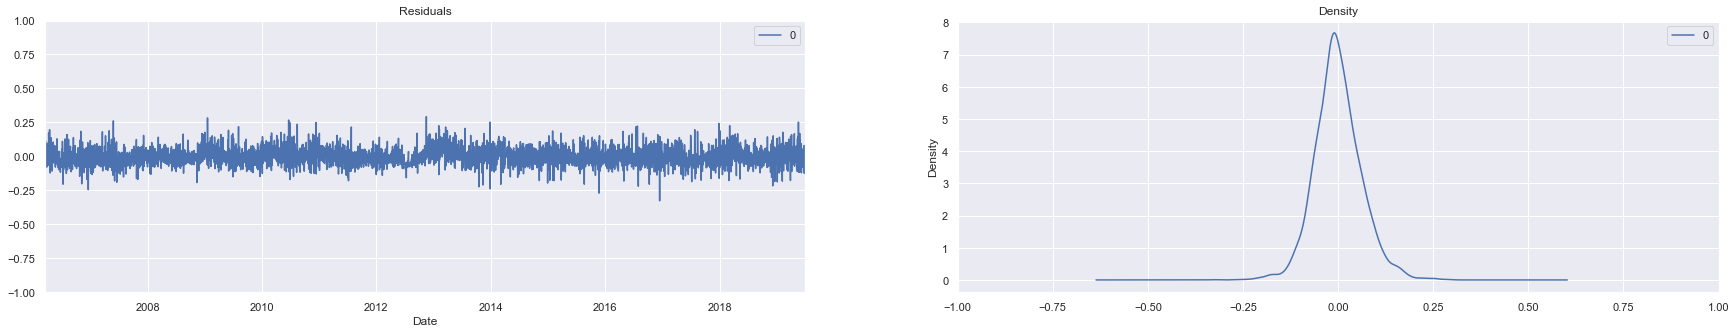

In [349]:
residuals = pd.DataFrame(res.resid)
f, ax = plt.subplots(1, 2, figsize=(30,5))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].set_ylim([-1,1])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim([-1,1])
plt.show()

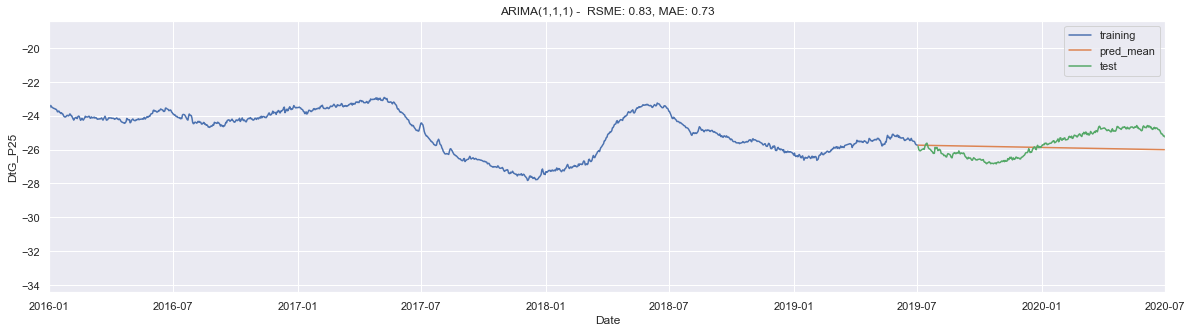

In [350]:
plot_model_performance(y_train, pd.Series(res.forecast(len(test.index))[0], index=test.index), y_test, 'ARIMA(1,1,1)', '2016-01-01', '2020-07-01')

In [351]:
forecast_frame = walk_forward_prediction_ARIMA(y_train, y_test, 30)

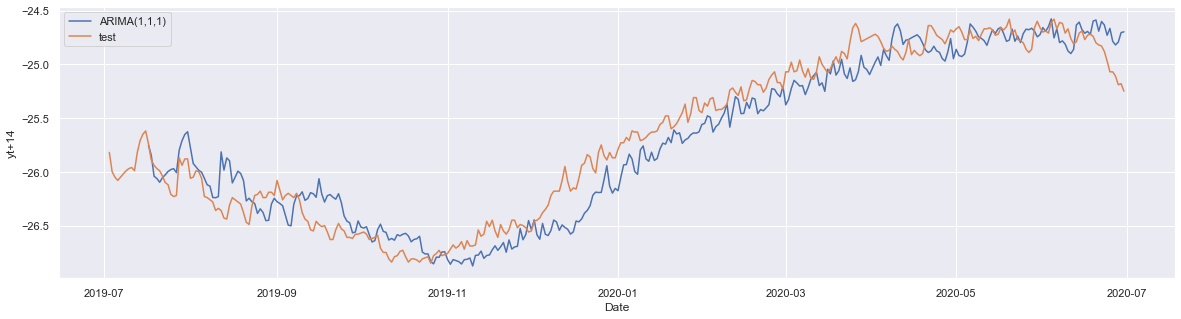

In [364]:
pred = forecast_frame['yt+14'].shift(14).dropna()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
#sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = pred.index, y=pred, label='ARIMA(1,1,1)')
sns.lineplot(x = test.index, y=y_test, label='test')
#ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, pred),3)}, RSME: {RSME(y_test, pred)}, MAE: {MAE(y_test, pred)}')
plt.show()

## Facebook Prophet

In [323]:
from fbprophet import Prophet

In [384]:
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ['ds', 'y']

In [385]:
m_prophet_1 = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
m_prophet_1.fit(y_train_prophet)

In [386]:
future_frame = m_prophet_1.make_future_dataframe(periods=len(y_test), freq='D', include_history=False)
prophet_simple = m_prophet_1.predict(future_frame)

In [387]:
y_test

Date
2019-07-03   -25.82
2019-07-04   -26.00
2019-07-05   -26.05
2019-07-06   -26.08
2019-07-07   -26.05
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Freq: D, Name: DtG_P25, Length: 364, dtype: float64

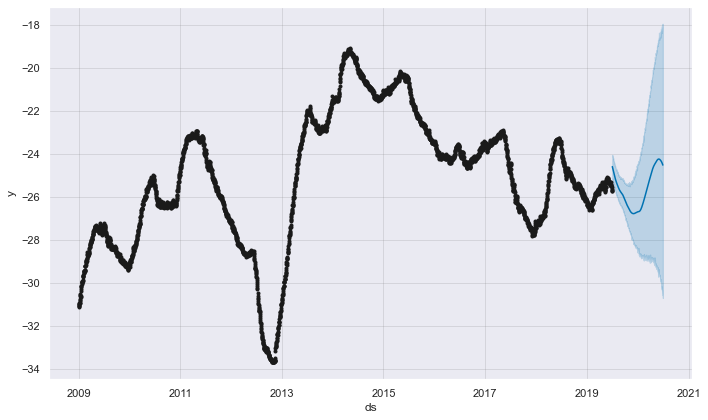

In [388]:
m1 = m_prophet_1.plot(prophet_simple)

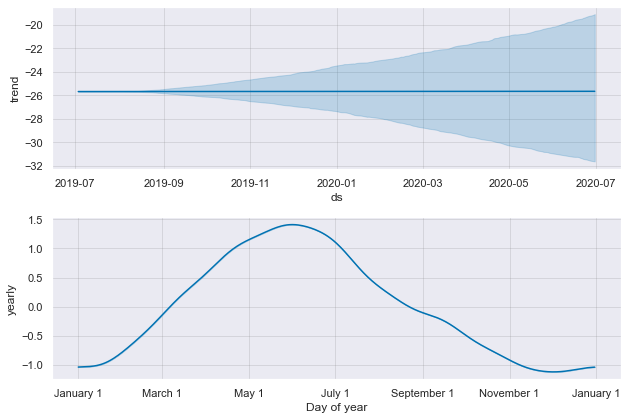

In [389]:
comp = m_prophet_1.plot_components(prophet_simple)

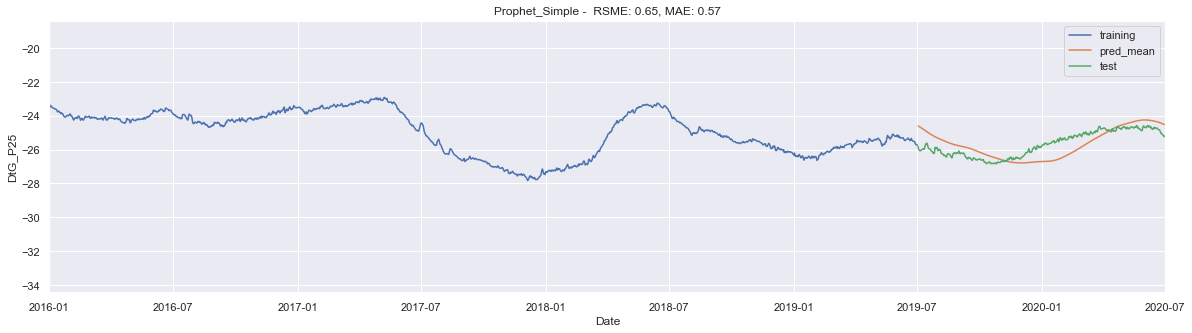

In [390]:
plot_model_performance(y_train, prophet_simple.set_index('ds').yhat, y_test, 'Prophet_Simple', '2016-01-01', '2020-07-01')

### Addition of regressors

In [391]:
train_prophet = train.reset_index()
train_prophet.rename(columns = {'Date' : 'ds', 'DtG_P25' : 'y'}, inplace=True)

In [392]:
regressors = ['T_BU', 'Rf_BU', 'V_Pe', 'H_FCP']
m_prophet_2 = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
for regressor in regressors:
    m_prophet_2.add_regressor(regressor, mode='additive')
m_prophet_2.fit(train_prophet)

In [394]:
future_frame = m_prophet_2.make_future_dataframe(periods=len(test), freq='7D', include_history=False)

In [395]:
future_frame = future_frame.join(test[regressors].reset_index(drop=True))

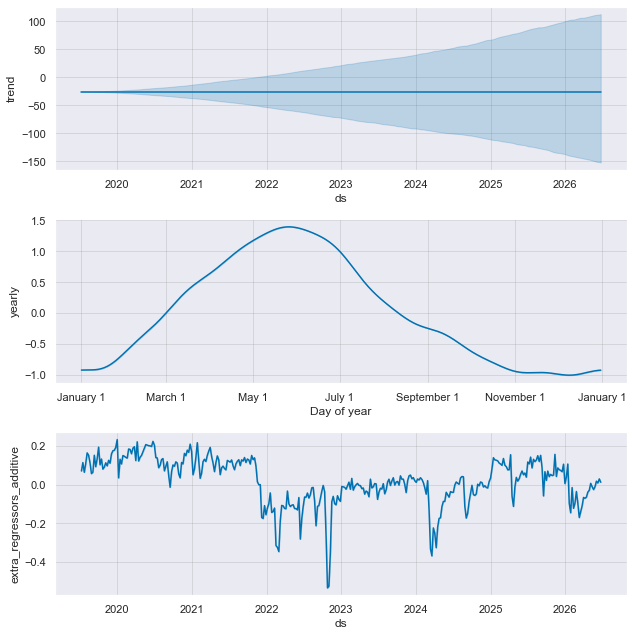

In [396]:
prophet_complex = m_prophet_2.predict(future_frame)
fig = m_prophet_2.plot_components(prophet_complex)

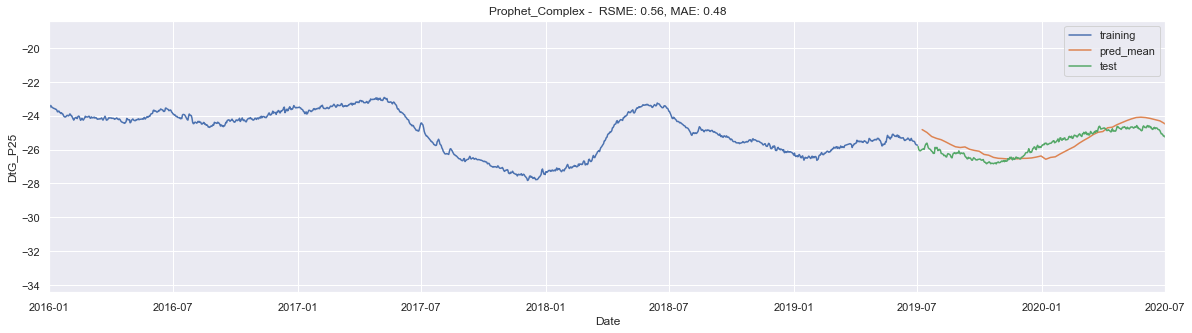

In [397]:
plot_model_performance(y_train, prophet_complex.set_index('ds').yhat, y_test, 'Prophet_Complex', '2016-01-01', '2020-07-01')

## XBoost Trees

In [748]:
train.columns

Index(['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP',
       'Rf_BU_trend', 'DtG_P24_trend', 'DtG_P25_trend', 'T_BU_trend',
       'T_Pe_trend', 'V_Pe_trend', 'H_FCP_trend', 'V_Pe_trend_4M',
       'H_FCP_trend_6M', 'Rf_BU_trend_6M'],
      dtype='object')

In [507]:
(X_train.index.year - 2008) * X_train.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            66, 66, 66, 66, 66, 66, 66, 66, 77, 77],
           dtype='int64', name='Date', length=3835)

In [776]:
x_columns = ['T_BU', 'Rf_BU', 'V_Pe', 'H_FCP', 'V_Pe_trend_4M', 'H_FCP_trend_6M', 'Rf_BU_trend_6M']
y_train = train['DtG_P25']
X_train = train[x_columns]
X_train = X_train.join(pd.get_dummies(season(X_train.index), drop_first=True).set_index(X_train.index))
X_train['year'] = X_train.index.year
#X_train['sin_year'] = np.sin(2*np.pi*X_train.index.dayofyear/365.25)
#X_train['cos_year'] = np.cos(2*np.pi*X_train.index.dayofyear/365.25)
#X_train['day'] = X_train.index.dayofyear
#X_train['month'] = (X_train.index.year - 2008) * X_train.index.quarter
y_test = test['DtG_P25']
X_test = test[x_columns]
X_test = X_test.join(pd.get_dummies(season(X_test.index), drop_first=True).set_index(X_test.index))
X_test['year'] = X_test.index.year
#X_test['month'] = (X_test.index.year - 2008) * X_test.index.quarter

In [777]:
from catboost import CatBoostRegressor

In [809]:
boost = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=3, verbose=False)

In [810]:
boost.fit(X_train, y_train)

In [811]:
yhat = pd.Series(boost.predict(X_train), index=X_train.index)

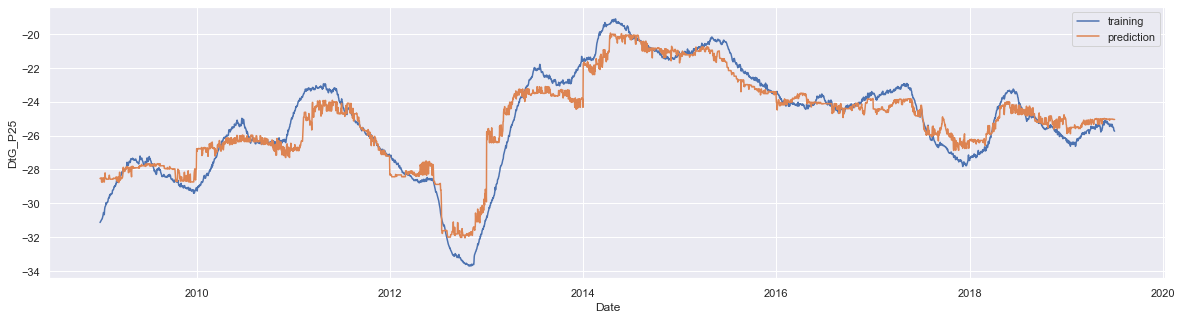

In [812]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = yhat.index, y=yhat, label='prediction')
plt.show()

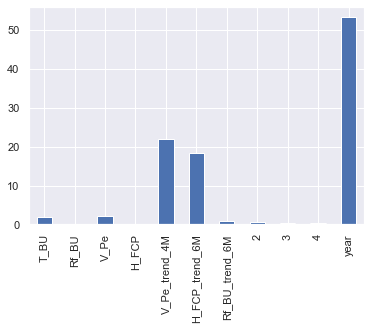

In [813]:
pd.Series(boost.feature_importances_, index=X_train.columns).plot(kind='bar')

### CV Xboost

In [814]:
X_training, X_validation = cv_split(X_train, 5)
y_training, y_validation = cv_split(y_train, 5)

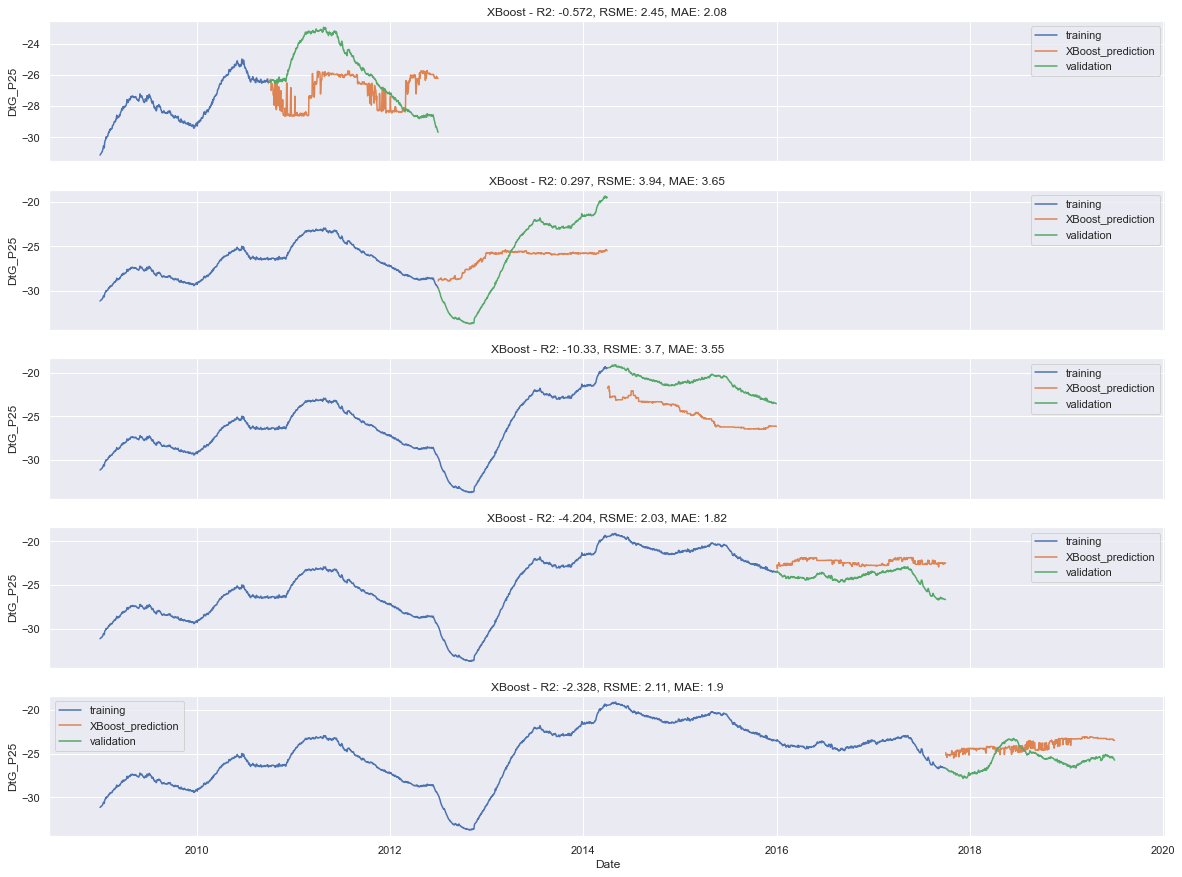

In [815]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,15), sharex=True)
for i in range(5):
    boost.fit(X_training[i], y_training[i])
    prediction = pd.Series(boost.predict(X_validation[i]), index=X_validation[i].index)
    
    sns.lineplot(x = y_training[i].index, y=y_training[i], label='training', ax=ax[i])
    sns.lineplot(x = prediction.index, y=prediction, label='XBoost_prediction', ax=ax[i])
    sns.lineplot(x = y_validation[i].index, y=y_validation[i], label='validation', ax=ax[i])
    ax[i].set_title(f'XBoost - R2: {round(r2_score(y_validation[i], prediction),3)}, RSME: {RSME(y_validation[i], prediction)}, MAE: {MAE(y_validation[i], prediction)}')
plt.show()

### Xboost on Test

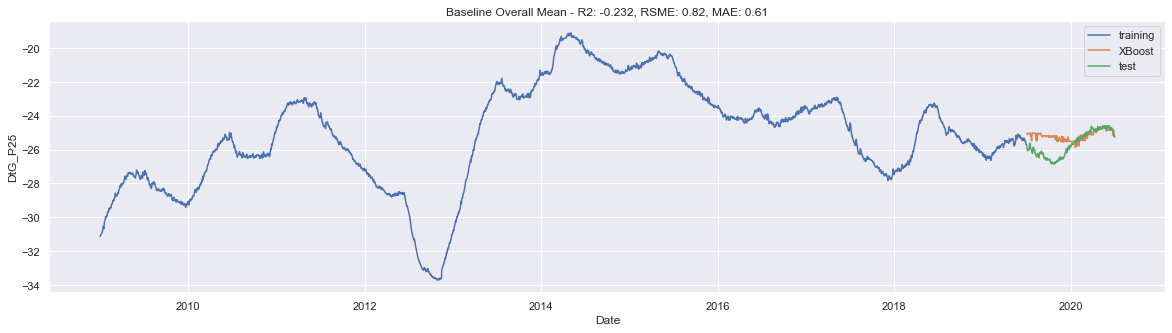

In [816]:
boost.fit(X_train, y_train)
boost_forecast = boost.predict(X_test)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=boost_forecast, label='XBoost')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, boost_forecast),3)}, RSME: {RSME(y_test, boost_forecast)}, MAE: {MAE(y_test, boost_forecast)}')
plt.show()

In [828]:
## Lagged features of X
x_columns = ['T_BU', 'Rf_BU', 'V_Pe', 'H_FCP', 'V_Pe_trend_4M', 'H_FCP_trend_6M', 'Rf_BU_trend_6M']
X_train_lagged = train['DtG_P25']
X_train_lagged = train[x_columns]
X_train_lagged['DtG_P25_shifted'] = train['DtG_P25'].shift(30)
X_train_lagged = X_train_lagged.join(pd.get_dummies(season(X_train.index), drop_first=True).set_index(X_train.index))
X_train_lagged['year'] = X_train_lagged.index.year

y_test_lagged = test['DtG_P25']
X_test_lagged = test[x_columns]
X_test_lagged['DtG_P25_shifted'] = test['DtG_P25'].shift(30)
X_test = X_test_lagged.join(pd.get_dummies(season(X_test_lagged.index), drop_first=True).set_index(X_test.index))
X_test['year'] = X_test.index.year

<ipython-input-828-fb71a4667479>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_lagged['DtG_P25_shifted'] = train['DtG_P25'].shift(30)
<ipython-input-828-fb71a4667479>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lagged['DtG_P25_shifted'] = test['DtG_P25'].shift(30)


In [823]:
boost = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=3, verbose=False)
boost.fit(X_train_lagged, y_train)
yhat = pd.Series(boost.predict(X_train_lagged), index=X_train_lagged.index)

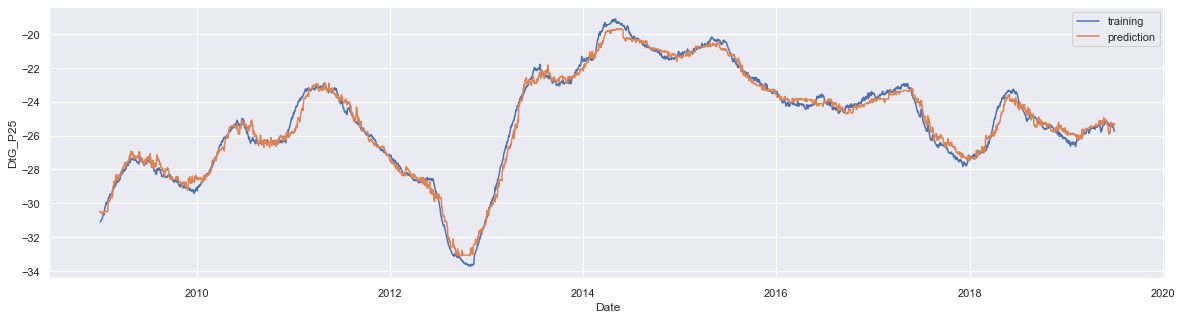

In [824]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train_lagged.index, y=y_train_lagged, label='training')
sns.lineplot(x = yhat.index, y=yhat, label='prediction')
plt.show()

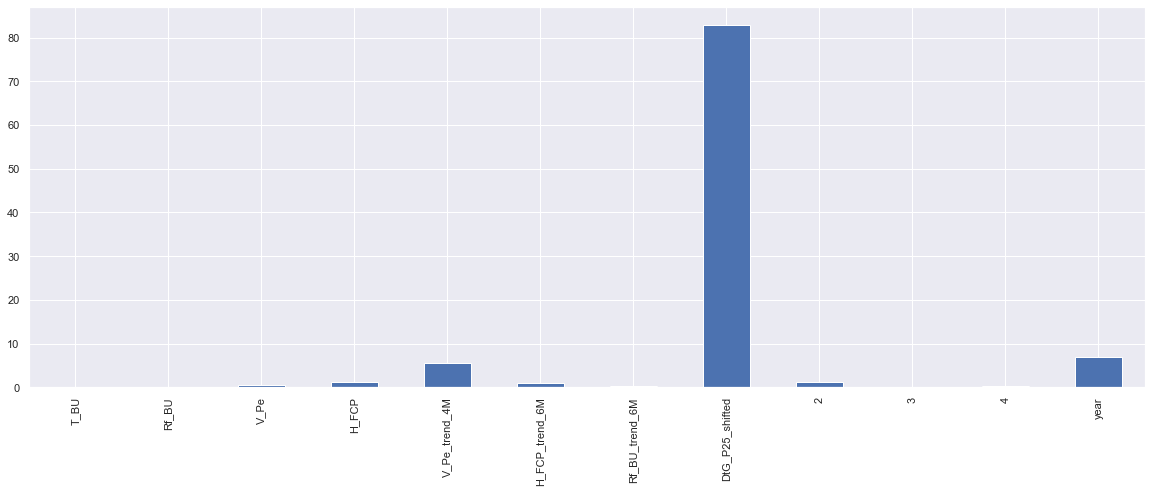

In [825]:
plt.figure(figsize=(20,7))
pd.Series(boost.feature_importances_, index=X_train_lagged.columns).plot(kind='bar')

In [826]:
X_training, X_validation = cv_split(X_train_lagged, 5)
y_training, y_validation = cv_split(y_train, 5)

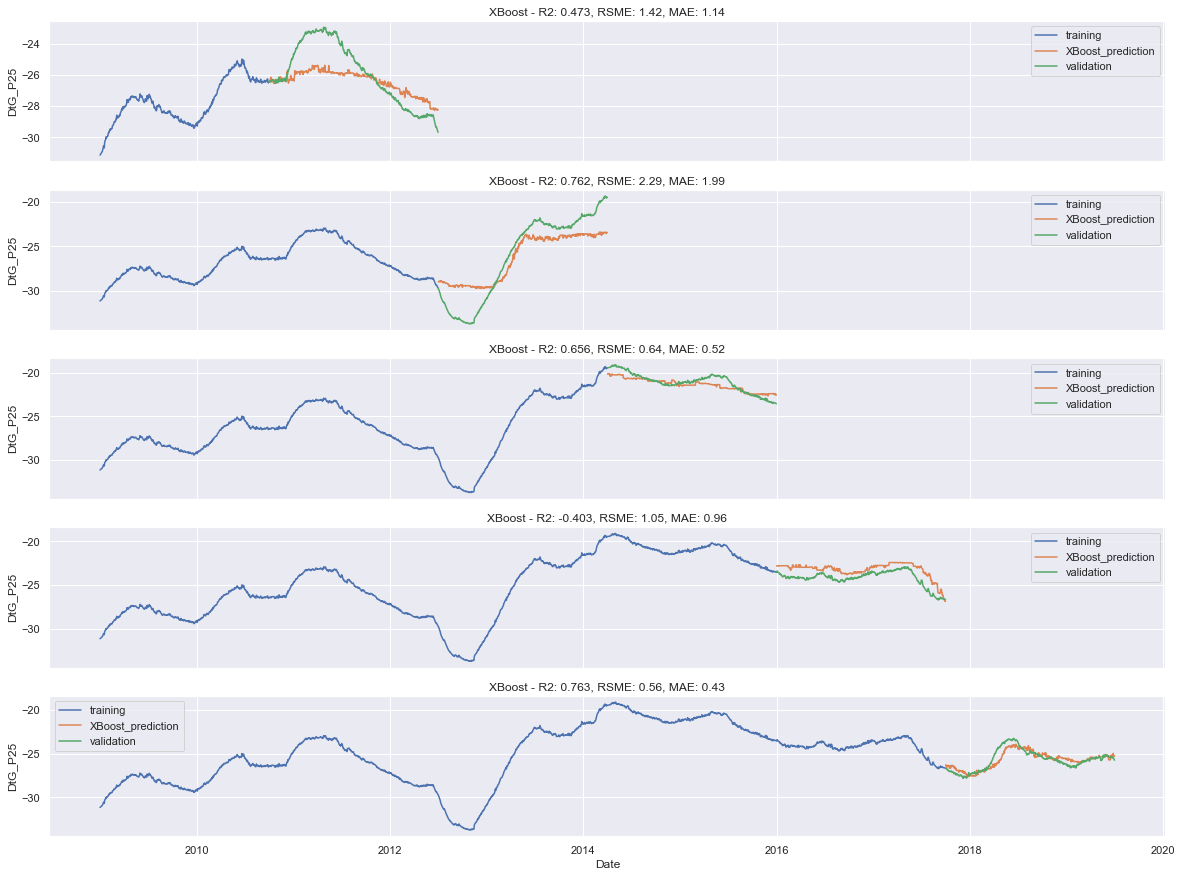

In [827]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,15), sharex=True)
for i in range(5):
    boost.fit(X_training[i], y_training[i])
    prediction = pd.Series(boost.predict(X_validation[i]), index=X_validation[i].index)
    
    sns.lineplot(x = y_training[i].index, y=y_training[i], label='training', ax=ax[i])
    sns.lineplot(x = prediction.index, y=prediction, label='XBoost_prediction', ax=ax[i])
    sns.lineplot(x = y_validation[i].index, y=y_validation[i], label='validation', ax=ax[i])
    ax[i].set_title(f'XBoost - R2: {round(r2_score(y_validation[i], prediction),3)}, RSME: {RSME(y_validation[i], prediction)}, MAE: {MAE(y_validation[i], prediction)}')
plt.show()